## **Waste classification**

The project concerns waste classification to determine if it may be recycle or not. The dataset contains waste images  recyclable and organic ones. We will try to train a model that will be able to  recognise them all.
It is a binary classification problem and we will train the model in TensorFlow.

**Data**

The dataset contains images divided into two classes: organic waste and recycle waste and it is split into train data (85%) and test data (15%).
Training dataset contains 22564 images while test dataset 2513 images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization


In [6]:
from google.colab import files
files.upload()  # Select kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronisaac44","key":"4c3c43e858c9ac7859a5bbce8512a481"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d techsash/waste-classification-data
!unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

### **Data preparation**

In [10]:
train_dir = '/content/dataset/DATASET/TRAIN'
test_dir = '/content/dataset/DATASET/TEST'

We load images with **image_dataset_from_directory** - this method returns an object **tf.data.Dataset**.

We define some of parameters:

In [4]:
batch_size = 32
img_height = 64
img_width = 64

Create a dataset:

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22564 files belonging to 2 classes.
Using 18052 files for training.


In [12]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2513 files belonging to 2 classes.
Using 502 files for validation.


The class names can be found in the attribute class_names. They correspond to directory names in alphabetical order.

In [14]:
class_names = train_ds.class_names
print(class_names)

['O', 'R']


 **Data visualization**

Here there are first 9 images from the training dataset.

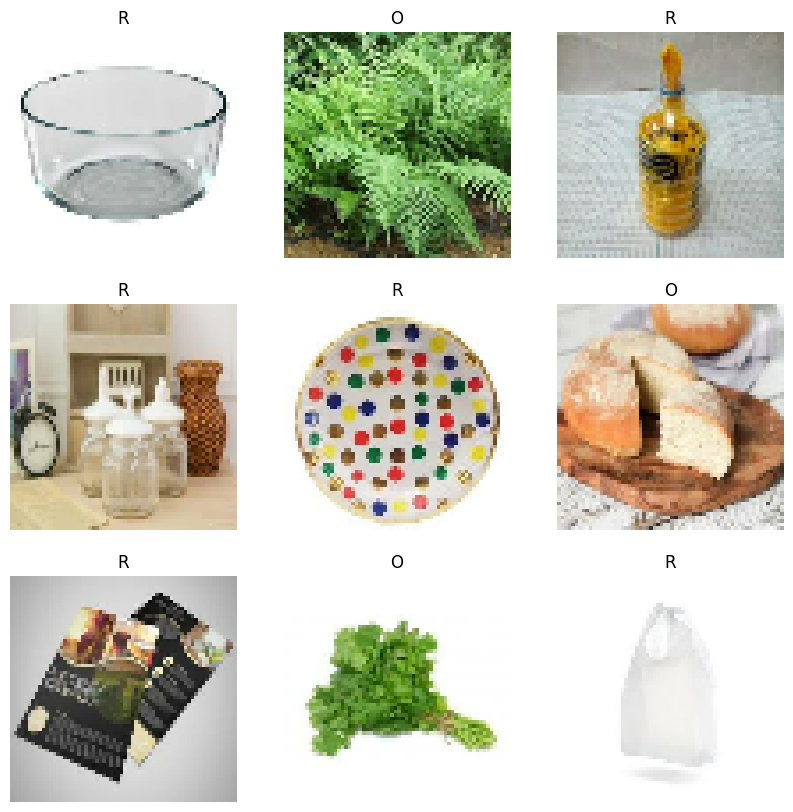

In [15]:
plt.figure(figsize= (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

Shape of data:

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 64, 64, 3)
(32,)


**Data standardization**

The RGB channel values fall into the [0, 255] range. We have to standardize values to be in the [0, 1] range. We use a Rescaling layer for it.

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
X_train, y_train = next(iter(normalized_ds))
first_image = X_train[0]
print(np.min(first_image), np.max(first_image))

0.016308594 0.9952822


In [20]:
normalized_test = test_ds.map(lambda x, y: (normalization_layer(x), y))
X_test, y_test = next(iter(normalized_test))
first_img = X_test[0]
print(np.min(first_img), np.max(first_img))

0.0 1.0


### **Creating the model**

We build model with Convolutional Neural Network (CNN) and we will test a few models.

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with three Dense layers. First two layers are activated by a relu activation function and the last is activated by a sigmoid activation function.

Compile the model:

We choose the Adam optimizer and the loss function: binary_crossentropy. To view training and validation accuracy for each training epoch, we use metrics "accuracy".


In [21]:
model = Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,377 (2.14 MB)

 Trainable params: 561,377 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

We train the model for 30 epoch.

In [23]:
history = model.fit(
    X_train, y_train,
    epochs = 30,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6250 - loss: 0.6892 - val_accuracy: 0.3438 - val_loss: 0.8080
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.6647 - val_accuracy: 0.3438 - val_loss: 0.7622
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6250 - loss: 0.6521 - val_accuracy: 0.3438 - val_loss: 0.7931
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6250 - loss: 0.6270 - val_accuracy: 0.3438 - val_loss: 0.8667
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6250 - loss: 0.6112 - val_accuracy: 0.6875 - val_loss: 0.6621
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8750 - loss: 0.5889 - val_accuracy: 0.3750 - val_loss: 0.7181
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7500 - loss: 0.5300 - val_accuracy: 0.3438 - val_loss: 0.8786
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6562 - loss: 0.5118 - val_accuracy: 0.7500 - val_loss: 0.6300
Ep

In [24]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.6562



**Visualization training results**

The plots of loss and accuracy on the training and validation sets.

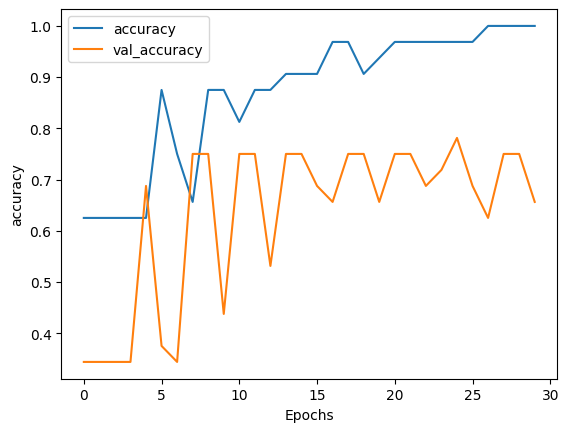

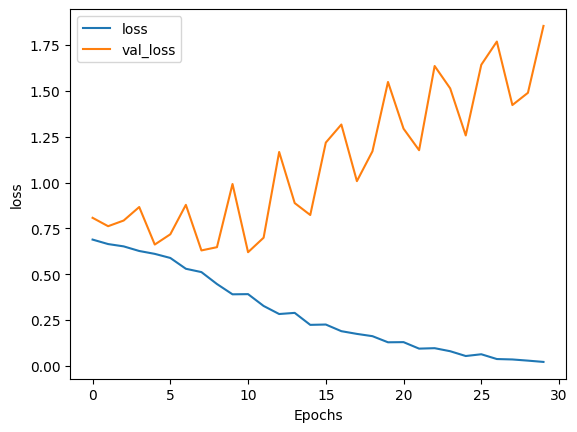

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

From the above plots one can see that difference in accuracy between training and validation set is noticeable. We are dealing with overfitting. The training accuracy is increasing over time, whereas validation accuracy achieved 78% in the training process.

In this case from this dataset is difficult to achieve good accuracy with a CNN created from scratch.


**Model 2**

In model two we add additional convolution layers and we reduce the complexity of architecture in fully connected layer to have a better accuracy. We also are adding Dropout layer to fight with overfitting in the training process.


In [26]:
model2 = Sequential([
   tf.keras.layers.Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(64, activation="relu"),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(32, activation="relu"),
   tf.keras.layers.Dense(1, activation="sigmoid")
])

model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,745 (920.88 KB)

 Trainable params: 235,745 (920.88 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_2 = model2.fit(
    X_train, y_train,
    epochs = 30,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 0.7004 - val_accuracy: 0.3438 - val_loss: 0.7474
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6250 - loss: 0.6544 - val_accuracy: 0.3438 - val_loss: 0.8570
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6250 - loss: 0.6755 - val_accuracy: 0.3438 - val_loss: 0.8911
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6250 - loss: 0.6688 - val_accuracy: 0.3438 - val_loss: 0.8123
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6250 - loss: 0.6733 - val_accuracy: 0.3438 - val_loss: 0.7409
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6562 - loss: 0.6384 - val_accuracy: 0.3438 - val_loss: 0.7218
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6562 - loss: 0.6364 - val_accuracy: 0.3438 - val_loss: 0.7519
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6562 - loss: 0.6222 - val_accuracy: 0.3438 - val_loss: 0.811

In [28]:
loss, accuracy = model2.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9375
Testing Accuracy:  0.8125


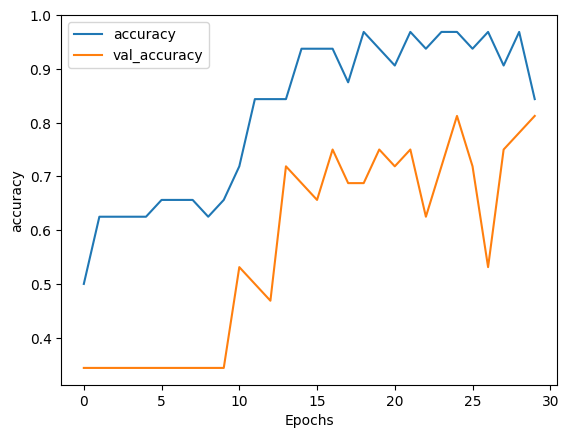

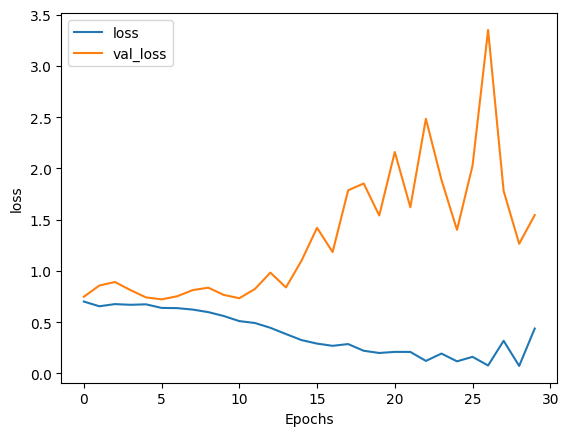

In [29]:
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

The validation accuracy is achieved 81% in the training process.

The training accuracy is increasing over time, whereas validation accuracy stalls around 80% in the training process. We also see that the overfitting slightly decreased. The validation loss reaches a minimum value after 5 epochs, and then stabilizes, with the training loss decreasing linearly until the values are close to 0.

**Model 3**

We also may add Batch Normalization to reduce overfitting.

In [30]:
model3 = Sequential([
   tf.keras.layers.Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu', padding='same'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(64, activation="relu"),
   tf.keras.layers.Dense(32, activation="relu"),
   tf.keras.layers.Dense(1, activation="sigmoid")
])

model3.compile(optimizer='adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,769 (924.88 KB)

 Trainable params: 236,257 (922.88 KB)

 Non-trainable params: 512 (2.00 KB)

In this case we train the model for 40 epoch.

In [31]:
history_3 = model3.fit(
    X_train, y_train,
    epochs = 40,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.3750 - loss: 2.6259 - val_accuracy: 0.3438 - val_loss: 0.7053
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step - accuracy: 0.7500 - loss: 0.5452 - val_accuracy: 0.3438 - val_loss: 0.7150
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8438 - loss: 0.4180 - val_accuracy: 0.3438 - val_loss: 0.7099
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.1683 - val_accuracy: 0.3438 - val_loss: 0.7039
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0953 - val_accuracy: 0.3438 - val_loss: 0.7000
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0576 - val_accuracy: 0.3750 - val_loss: 0.6976
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0386 - val_accuracy: 0.4062 - val_loss: 0.6964
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.4375 - val_loss: 0.69

In [32]:
loss, accuracy = model3.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6562


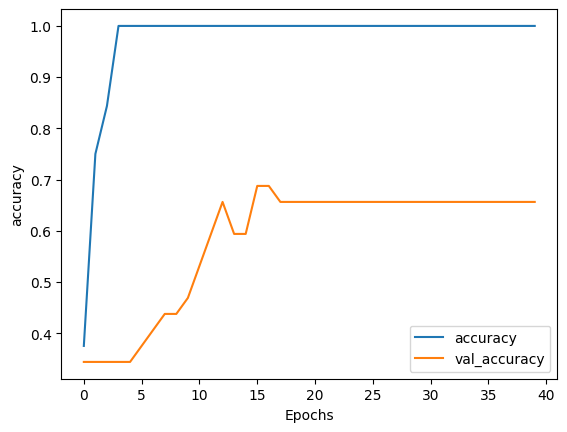

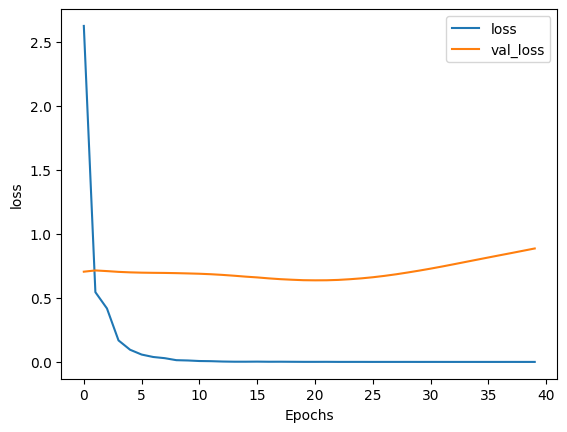

In [33]:
plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

In this case we achaived the worst validation accuracy equal to 65% in the training process. We see that the training accuracy is increasing over time, whereas validation accuracy stalls around 65% in the training process. Unfortunately the overfitting has grown significantly.
